# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

## 5.18 Table B.7 contains daily closing stock prices for the Whole Foods 
Market.
 Develop an appropriate ARIMA model and a procedure for these data. Explain how prediction intervals would b 
computed.

In [3]:
import pandas as pd
import re
from io import StringIO

# Raw data from the user with commas inserted
raw_data = """
1/2/01 28.05 3/15/01 22.01 5/25/01 27.88 8/7/01 32.24 10/23/01 35.20 1/3/01 28.23 3/16/01 22.26 5/29/01 27.78 8/8/01 31.60 10/24/01 35.30
1/4/01 26.25 3/19/01 22.35 5/30/01 28.03 8/9/01 31.78 10/25/01 35.65 1/5/01 25.41 3/20/01 23.06 5/31/01 28.36 8/10/01 32.99 10/26/01 35.96
1/8/01 26.25 3/21/01 22.78 6/1/01 28.31 8/13/01 32.69 10/29/01 35.86 1/9/01 26.03 3/22/01 22.19 6/4/01 27.58 8/14/01 33.31 10/30/01 35.61
1/10/01 26.09 3/23/01 22.19 6/5/01 27.43 8/15/01 32.78 10/31/01 34.42 1/11/01 26.28 3/26/01 22.66 6/6/01 27.16 8/16/01 32.78 11/1/01 34.55
1/12/01 26.00 3/27/01 22.50 6/7/01 27.92 8/17/01 32.82 11/2/01 35.43 1/16/01 25.63 3/28/01 21.36 6/8/01 27.36 8/20/01 33.04 11/5/01 34.92
1/17/01 25.57 3/29/01 20.71 6/11/01 27.17 8/21/01 33.79 11/6/01 35.56 1/18/01 25.57 3/30/01 20.86 6/12/01 27.39 8/22/01 32.69 11/7/01 35.85
1/19/01 25.16 4/2/01 20.95 6/13/01 27.58 8/23/01 32.40 11/8/01 36.89 1/22/01 26.52 4/3/01 20.12 6/14/01 27.55 8/24/01 32.91 11/9/01 37.24
1/23/01 27.18 4/4/01 19.50 6/15/01 27.49 8/27/01 33.38 11/12/01 37.01 1/24/01 26.93 4/5/01 20.30 6/18/01 27.70 8/28/01 34.72 11/13/01 37.52
1/25/01 26.50 4/6/01 20.09 6/19/01 27.19 8/29/01 35.22 11/14/01 37.24 1/26/01 26.50 4/9/01 20.38 6/20/01 26.76 8/30/01 34.77 11/15/01 40.36
1/29/01 27.27 4/10/01 21.13 6/21/01 26.53 8/31/01 34.85 11/16/01 39.42 1/30/01 27.70 4/11/01 20.63 6/22/01 26.45 9/4/01 33.91 11/19/01 40.16
1/31/01 28.17 4/12/01 20.35 6/25/01 25.97 9/5/01 34.39 11/20/01 42.64 2/1/01 28.26 4/16/01 20.39 6/26/01 26.11 9/6/01 34.49 11/21/01 41.86
2/2/01 28.29 4/17/01 20.95 6/27/01 26.50 9/7/01 34.37 11/23/01 42.58 2/5/01 28.23 4/18/01 21.94 6/28/01 26.98 9/10/01 33.44 11/26/01 42.63
2/6/01 28.54 4/19/01 21.43 6/29/01 26.84 9/17/01 33.24 11/27/01 42.14 2/7/01 28.94 4/20/01 21.37 7/2/01 28.03 9/18/01 33.18 11/28/01 41.62
2/8/01 28.51 4/23/01 21.24 7/3/01 28.00 9/19/01 31.26 11/29/01 42.59 2/9/01 27.55 4/24/01 21.13 7/5/01 28.01 9/20/01 31.04 11/30/01 42.50
2/12/01 28.05 4/25/01 22.36 7/6/01 27.20 9/21/01 30.33 12/3/01 42.38 2/13/01 27.98 4/26/01 22.93 7/9/01 27.92 9/24/01 30.69 12/4/01 42.77
2/14/01 23.55 4/27/01 23.26 7/10/01 27.10 9/25/01 30.84 12/5/01 43.80 2/15/01 24.21 4/30/01 24.07 7/11/01 27.15 9/26/01 29.95 12/6/01 45.13
2/16/01 23.92 5/1/01 23.79 7/12/01 27.19 9/27/01 29.22 12/7/01 45.40 2/20/01 23.77 5/2/01 24.56 7/13/01 26.69 9/28/01 31.11 12/10/01 43.81
2/21/01 23.74 5/3/01 24.43 7/16/01 26.79 10/1/01 30.93 12/11/01 42.16 2/22/01 23.55 5/4/01 24.29 7/17/01 27.17 10/2/01 30.98 12/12/01 41.24
2/23/01 23.34 5/7/01 23.33 7/18/01 26.72 10/3/01 32.59 12/13/01 40.91 2/26/01 23.22 5/8/01 25.20 7/19/01 26.33 10/4/01 32.50 12/14/01 41.05
2/27/01 22.87 5/9/01 24.94 7/20/01 26.23 10/5/01 32.12 12/17/01 41.13 2/28/01 21.36 5/10/01 24.95 7/23/01 26.59 10/8/01 32.09 12/18/01 41.55
3/1/01 21.30 5/11/01 25.25 7/24/01 26.82 10/9/01 32.85 12/19/01 41.35 3/2/01 21.51 5/14/01 25.70 7/25/01 27.24 10/10/01 33.44 12/20/01 41.27
3/5/01 21.32 5/15/01 26.33 7/26/01 28.49 10/11/01 32.68 12/21/01 42.46 3/6/01 21.67 5/16/01 27.81 7/27/01 31.65 10/12/01 32.54 12/24/01 42.96
3/7/01 21.48 5/17/01 28.04 7/30/01 34.47 10/15/01 32.07 12/26/01 43.63 3/8/01 21.85 5/18/01 28.75 7/31/01 33.63 10/16/01 33.18 12/27/01 43.63
3/9/01 21.49 5/21/01 28.72 8/1/01 32.58 10/17/01 33.45 12/28/01 43.59 3/12/01 21.48 5/22/01 28.33 8/2/01 32.62 10/18/01 34.35 12/31/01 43.14
3/13/01 22.10 5/23/01 27.61 8/3/01 32.09 10/19/01 33.95 3/14/01 21.79 5/24/01 27.98 8/6/01 32.41 10/22/01 34.42
"""

# Flatten the string and split into date/value pairs
flat_data = re.split(r'[\s,]+', raw_data.strip())

# Extract date-price pairs
pairs = [(flat_data[i], float(flat_data[i + 1])) for i in range(0, len(flat_data), 2)]

# Create DataFrame
df = pd.DataFrame(pairs, columns=['Date', 'Price'])

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

# Set as index
df.set_index('Date', inplace=True)

df.head()

,Price
Date,
2001-01-02,28.05
2001-03-15,22.01
2001-05-25,27.88
2001-08-07,32.24
2001-10-23,35.20


In [4]:
# Move the rows into a proper chronological order
df.sort_index(inplace=True)

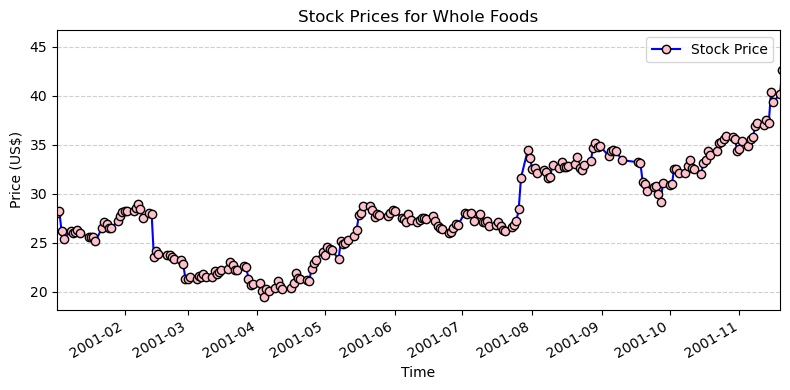

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df.index, df['Price'],
        color='blue',               # Line color
        marker='o',                 # Marker shape
        markerfacecolor='pink',     # Fill color of the marker
        markeredgecolor='black',    # Border color of the marker
        label='Stock Price')

# Labels and formatting
ax.set_xlabel('Time')
ax.set_ylabel('Price (US$)')
ax.set_title('Stock Prices for Whole Foods')
ax.set_xlim(pd.to_datetime('2001-01-02'), pd.to_datetime('2001-11-19'))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()

# Format the x-axis dates
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [6]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['Price'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.2043
p-value: 0.9725

p-value > alpha; H0: Not Stationary


In [7]:
# Difference the series if non-stationary
diff_series = df['Price'].diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -14.6008
p-value: 0.0000

p-value < alpha; Ha: Stationary


    d = 1

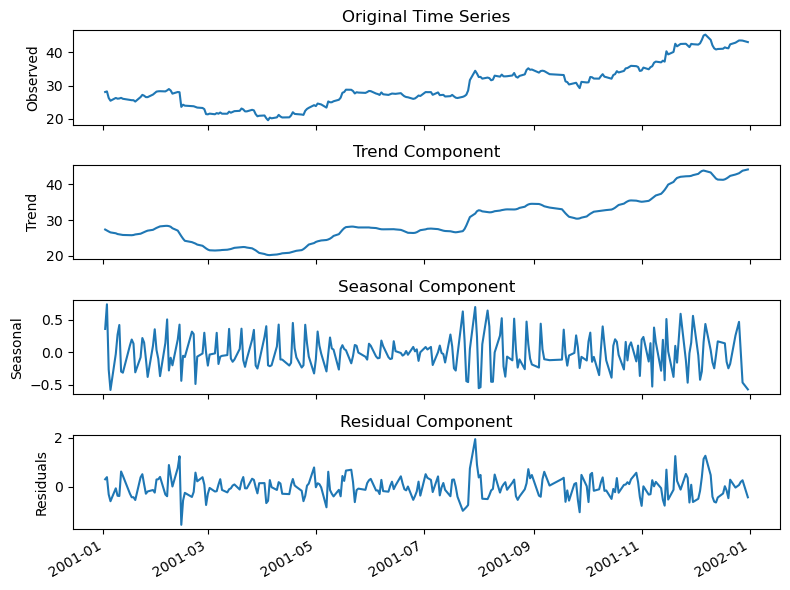

In [8]:
price_series = df['Price']

decom_price = STL(price_series, period=5).fit()  # Business week pattern, 5 days, period=5

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_price.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_price.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_price.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_price.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [9]:
# Define the seasonal periods to test (2 to 10)
seasonal_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop over seasonal periods and run the Canova-Hansen test
for S in seasonal_periods:
    print(f"Testing with seasonal period = {S}")
    
    ch_test = CHTest(m=S)   # Initialize the CHTest with the seasonal period

    D = ch_test.estimate_seasonal_differencing_term(price_series) # Estimate seasonal differencing term
    
    print(f"Suggested seasonal differencing term (D): {D}\n")

Testing with seasonal period = 2
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 3
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 4
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 5
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 6
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 7
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 8
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 9
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 10
Suggested seasonal differencing term (D): 0



In [10]:
# Perform a full grid search for ARIMA model only (non-seasonal)
auto_model_arima = pm.auto_arima(
    price_series,               # Time series data
    seasonal=False,             # Disable seasonal component (ARIMA only)
    d=1,                        # Set non-seasonal differencing
    start_p=0, max_p=3,         # p range: 0 to 3
    start_q=0, max_q=3,         # q range: 0 to 3
    stepwise=False,             # Full grid search
    trace=True,                 # Print model search process
    error_action='ignore',      # Skip models that fail
    suppress_warnings=True,     # Hide convergence warnings
    information_criterion='aic' # Use AIC to rank models
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=573.687, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=574.531, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=576.266, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=576.934, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=574.597, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=575.016, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=577.015, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=578.573, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=576.431, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=577.015, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=578.929, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=580.570, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=577.211, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=578.586, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=580.574, Time=0.10 sec

Best model:  ARIMA(0,1,0

In [11]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


pv, qv = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
dv = [1]                         # Set non-seasonal differencing

In [12]:
vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations

    print(f'Running model #{i} using ARIMA({p},{d},{q})')
    
    m = ARIMA(price_series, order=(p,d,q))   # Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'model': res                        # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()  

Running model #0 using ARIMA(0,1,0)
Running model #1 using ARIMA(0,1,1)
Running model #2 using ARIMA(0,1,2)
Running model #3 using ARIMA(0,1,3)
Running model #4 using ARIMA(1,1,0)
Running model #5 using ARIMA(1,1,1)
Running model #6 using ARIMA(1,1,2)
Running model #7 using ARIMA(1,1,3)
Running model #8 using ARIMA(2,1,0)
Running model #9 using ARIMA(2,1,1)
Running model #10 using ARIMA(2,1,2)
Running model #11 using ARIMA(2,1,3)
Running model #12 using ARIMA(3,1,0)
Running model #13 using ARIMA(3,1,1)
Running model #14 using ARIMA(3,1,2)
Running model #15 using ARIMA(3,1,3)



,index,order,AIC,AICc,model
0,0,"(0, 1, 0)",573.250417,573.266743,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,1,"(0, 1, 1)",573.892982,573.942163,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,4,"(1, 1, 0)",573.953258,574.002439,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,5,"(1, 1, 1)",574.462306,574.561071,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,2,"(0, 1, 2)",575.71631,575.815075,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [13]:
# Define the ARIMA model structure
modelM = ARIMA(endog=price_series,
                order=(0, 1, 0))

# Fit the model
model_fitM = modelM.fit()

# Display Summary
print(model_fitM.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  248
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -285.625
Date:                Fri, 04 Apr 2025   AIC                            573.250
Time:                        13:52:37   BIC                            576.760
Sample:                             0   HQIC                           574.663
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5915      0.026     22.868      0.000       0.541       0.642
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):               444.12
Prob(Q):                              0.29   Pr

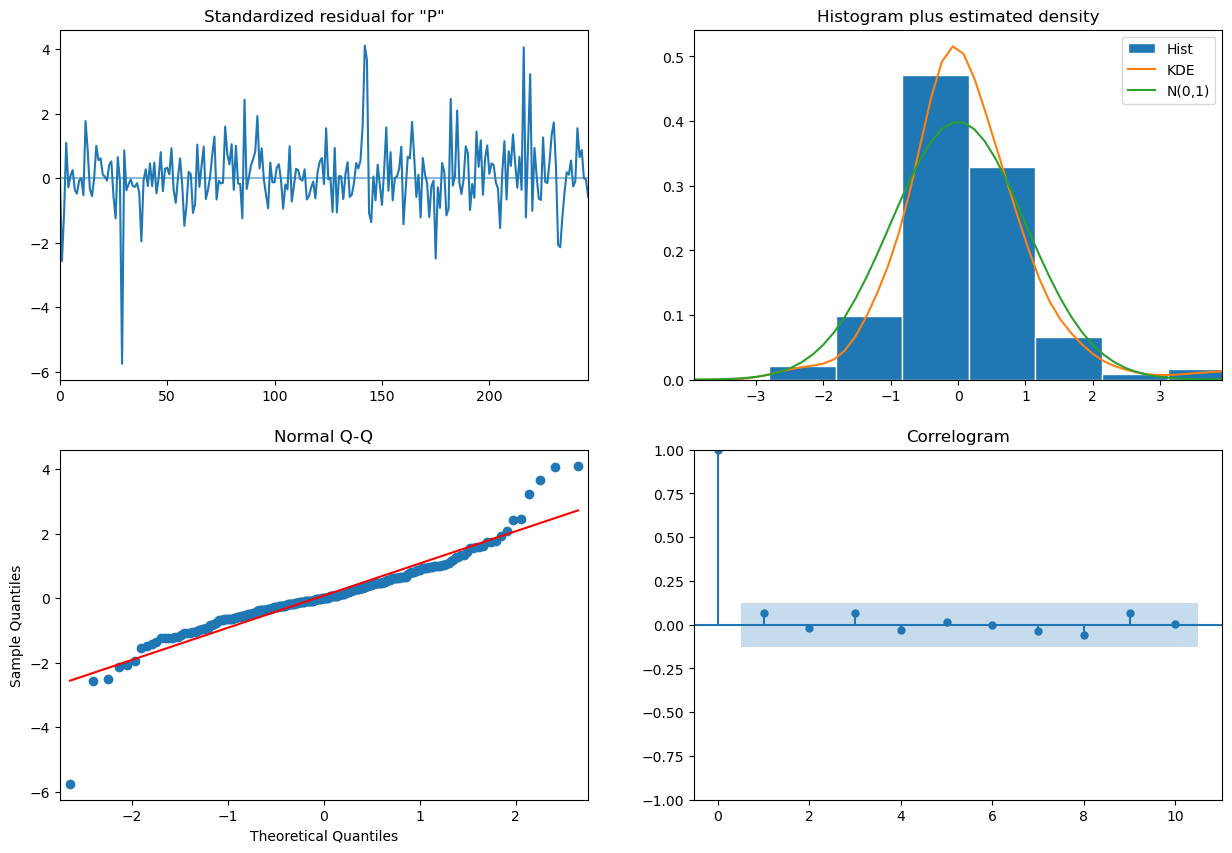

In [14]:
# Plots diagnostic checks for the fitted ARIMA model
model_fitM.plot_diagnostics(figsize=(15,10))
plt.show()

In [15]:
# Extract the residuals (errors) from the fitted model
residuals = model_fitM.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.048791,0.825180
2,1.117127,0.572030
3,1.192237,0.754867
4,1.279312,0.864876
5,1.290070,0.935950
6,1.290203,0.972195
7,1.291633,0.988662
8,1.393234,0.994342
9,1.395367,0.997851
10,1.398819,0.999217


In [16]:
# Get the values
fitted_seriesM = model_fitM.predict()

df['(0,1,0,0,0,0)'] = fitted_seriesM

df = df.iloc[1:]   # Drop the first row

df['Error'] = df['Price'] - df['(0,1,0,0,0,0)']

df.head()

,Price,"(0,1,0,0,0,0)",Error
Date,,,
2001-01-03,28.23,28.05,0.18
2001-01-04,26.25,28.23,-1.98
2001-01-05,25.41,26.25,-0.84
2001-01-08,26.25,25.41,0.84
2001-01-09,26.03,26.25,-0.22


In [17]:
df.tail()

,Price,"(0,1,0,0,0,0)",Error
Date,,,
2001-12-24,42.96,42.46,0.50
2001-12-26,43.63,42.96,0.67
2001-12-27,43.63,43.63,0.00
2001-12-28,43.59,43.63,-0.04
2001-12-31,43.14,43.59,-0.45


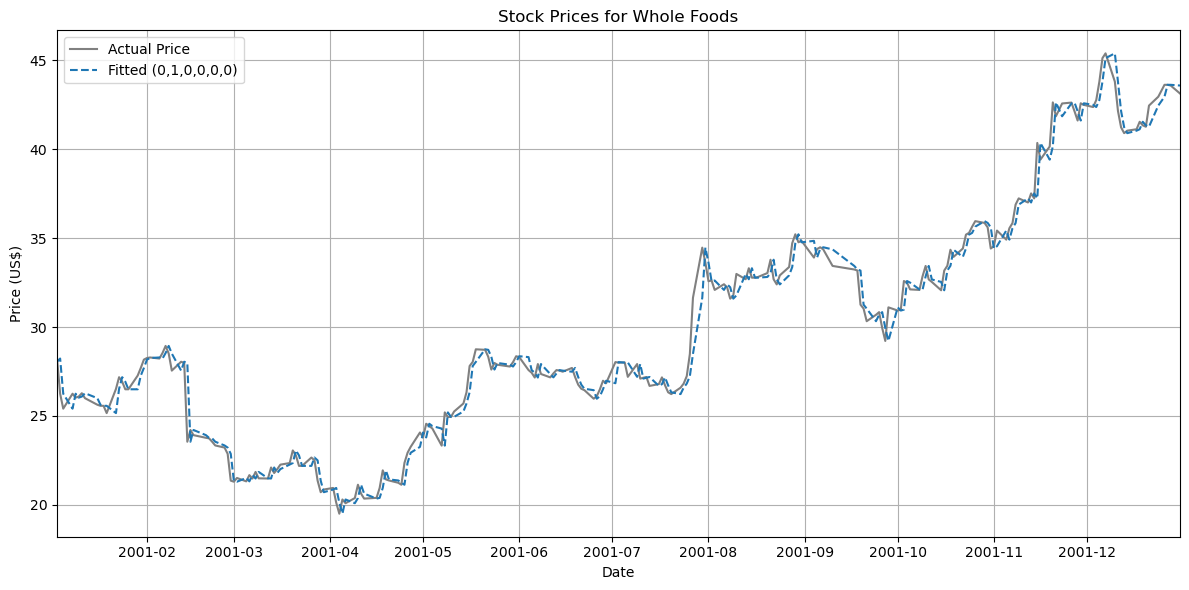

In [18]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df.index, df['Price'], label='Actual Price', color='gray')     # Actual
plt.plot(df.index, df['(0,1,0,0,0,0)'], label='Fitted (0,1,0,0,0,0)', linestyle='--')  # Fitted

plt.title('Stock Prices for Whole Foods')                      
plt.xlabel('Date')                                        
plt.ylabel('Price (US$)')  
plt.xlim(pd.to_datetime('2001-01-03'), pd.to_datetime('2001-12-31'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();      

In [19]:
# Calculate MAPE
mape = (np.abs(df['Error']) / df['Price']).mean() * 100

# Print the result
print(f"MAPE (0,1,0)(0,0,0): {mape:.2f}%")

MAPE (0,1,0)(0,0,0): 1.77%


In [20]:
# Forecast the next 5 time points
forecast_5m = model_fitM.get_forecast(steps=5)

# Extract predicted mean
forecast_mean_5m = forecast_5m.predicted_mean

# Extract confidence intervals
conf_int_5m = forecast_5m.conf_int()

# Get the last date from the original dataframe <====
last_date = df.index[-1]

# Create future dates for the forecast horizon <====
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq='B')  # 'B' = business day

# Reconstruct the forecast DataFrame with the correct index
forecast_resultm = pd.DataFrame({
    'Forecast': forecast_mean_5m.values,
    'Lower 95% CI': conf_int_5m.iloc[:, 0].values,
    'Upper 95% CI': conf_int_5m.iloc[:, 1].values
}, index=forecast_index)

forecast_resultm

,Forecast,Lower 95% CI,Upper 95% CI
2002-01-01,43.14,41.632631,44.647369
2002-01-02,43.14,41.008258,45.271742
2002-01-03,43.14,40.529160,45.750840
2002-01-04,43.14,40.125262,46.154738
2002-01-07,43.14,39.769420,46.510580


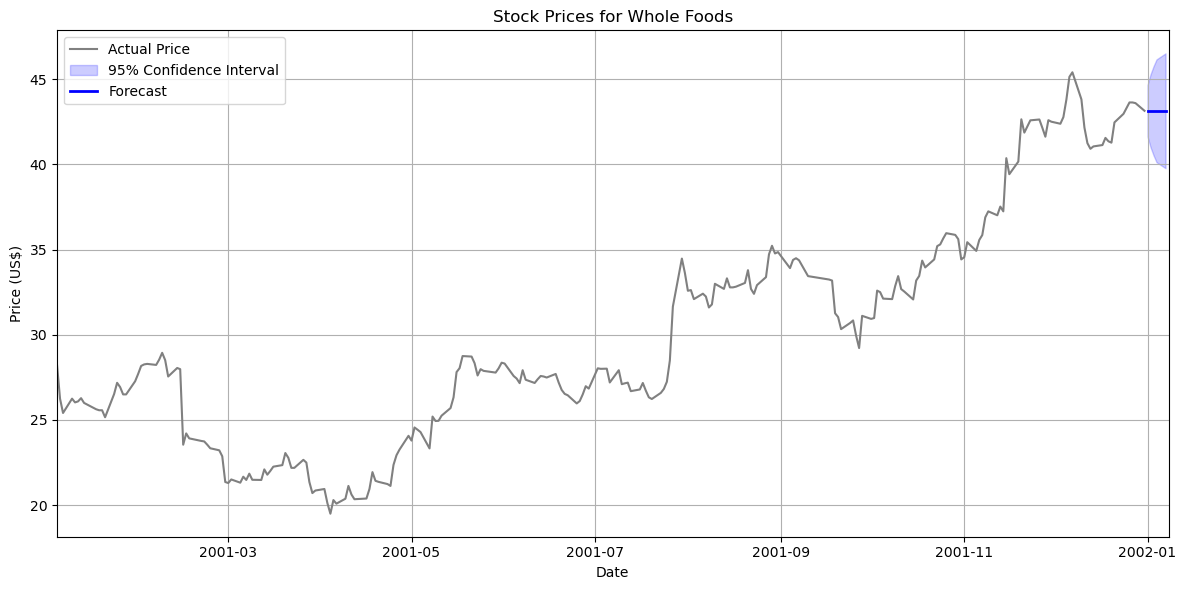

In [21]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(df.index, df['Price'], label='Actual Price', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_resultm.index,
                 conf_int_5m.iloc[:, 0],     # Lower bound
                 conf_int_5m.iloc[:, 1],     # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_resultm['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Stock Prices for Whole Foods')
plt.xlabel('Date')
plt.ylabel('Price (US$)')
plt.xlim(pd.to_datetime('2001-01-03'), pd.to_datetime('2002-01-8'))
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Testing Forecast with Past Data

In [22]:
# Raw data from the user with commas inserted
raw_data = """
1/2/01 28.05 3/15/01 22.01 5/25/01 27.88 8/7/01 32.24 10/23/01 35.20 1/3/01 28.23 3/16/01 22.26 5/29/01 27.78 8/8/01 31.60 10/24/01 35.30
1/4/01 26.25 3/19/01 22.35 5/30/01 28.03 8/9/01 31.78 10/25/01 35.65 1/5/01 25.41 3/20/01 23.06 5/31/01 28.36 8/10/01 32.99 10/26/01 35.96
1/8/01 26.25 3/21/01 22.78 6/1/01 28.31 8/13/01 32.69 10/29/01 35.86 1/9/01 26.03 3/22/01 22.19 6/4/01 27.58 8/14/01 33.31 10/30/01 35.61
1/10/01 26.09 3/23/01 22.19 6/5/01 27.43 8/15/01 32.78 10/31/01 34.42 1/11/01 26.28 3/26/01 22.66 6/6/01 27.16 8/16/01 32.78 11/1/01 34.55
1/12/01 26.00 3/27/01 22.50 6/7/01 27.92 8/17/01 32.82 11/2/01 35.43 1/16/01 25.63 3/28/01 21.36 6/8/01 27.36 8/20/01 33.04 11/5/01 34.92
1/17/01 25.57 3/29/01 20.71 6/11/01 27.17 8/21/01 33.79 11/6/01 35.56 1/18/01 25.57 3/30/01 20.86 6/12/01 27.39 8/22/01 32.69 11/7/01 35.85
1/19/01 25.16 4/2/01 20.95 6/13/01 27.58 8/23/01 32.40 11/8/01 36.89 1/22/01 26.52 4/3/01 20.12 6/14/01 27.55 8/24/01 32.91 11/9/01 37.24
1/23/01 27.18 4/4/01 19.50 6/15/01 27.49 8/27/01 33.38 11/12/01 37.01 1/24/01 26.93 4/5/01 20.30 6/18/01 27.70 8/28/01 34.72 11/13/01 37.52
1/25/01 26.50 4/6/01 20.09 6/19/01 27.19 8/29/01 35.22 11/14/01 37.24 1/26/01 26.50 4/9/01 20.38 6/20/01 26.76 8/30/01 34.77 11/15/01 40.36
1/29/01 27.27 4/10/01 21.13 6/21/01 26.53 8/31/01 34.85 11/16/01 39.42 1/30/01 27.70 4/11/01 20.63 6/22/01 26.45 9/4/01 33.91 11/19/01 40.16
1/31/01 28.17 4/12/01 20.35 6/25/01 25.97 9/5/01 34.39 11/20/01 42.64 2/1/01 28.26 4/16/01 20.39 6/26/01 26.11 9/6/01 34.49 11/21/01 41.86
2/2/01 28.29 4/17/01 20.95 6/27/01 26.50 9/7/01 34.37 11/23/01 42.58 2/5/01 28.23 4/18/01 21.94 6/28/01 26.98 9/10/01 33.44 11/26/01 42.63
2/6/01 28.54 4/19/01 21.43 6/29/01 26.84 9/17/01 33.24 11/27/01 42.14 2/7/01 28.94 4/20/01 21.37 7/2/01 28.03 9/18/01 33.18 11/28/01 41.62
2/8/01 28.51 4/23/01 21.24 7/3/01 28.00 9/19/01 31.26 11/29/01 42.59 2/9/01 27.55 4/24/01 21.13 7/5/01 28.01 9/20/01 31.04 11/30/01 42.50
2/12/01 28.05 4/25/01 22.36 7/6/01 27.20 9/21/01 30.33 12/3/01 42.38 2/13/01 27.98 4/26/01 22.93 7/9/01 27.92 9/24/01 30.69 12/4/01 42.77
2/14/01 23.55 4/27/01 23.26 7/10/01 27.10 9/25/01 30.84 12/5/01 43.80 2/15/01 24.21 4/30/01 24.07 7/11/01 27.15 9/26/01 29.95 12/6/01 45.13
2/16/01 23.92 5/1/01 23.79 7/12/01 27.19 9/27/01 29.22 12/7/01 45.40 2/20/01 23.77 5/2/01 24.56 7/13/01 26.69 9/28/01 31.11 12/10/01 43.81
2/21/01 23.74 5/3/01 24.43 7/16/01 26.79 10/1/01 30.93 12/11/01 42.16 2/22/01 23.55 5/4/01 24.29 7/17/01 27.17 10/2/01 30.98 12/12/01 41.24
2/23/01 23.34 5/7/01 23.33 7/18/01 26.72 10/3/01 32.59 12/13/01 40.91 2/26/01 23.22 5/8/01 25.20 7/19/01 26.33 10/4/01 32.50 12/14/01 41.05
2/27/01 22.87 5/9/01 24.94 7/20/01 26.23 10/5/01 32.12 12/17/01 41.13 2/28/01 21.36 5/10/01 24.95 7/23/01 26.59 10/8/01 32.09 12/18/01 41.55
3/1/01 21.30 5/11/01 25.25 7/24/01 26.82 10/9/01 32.85 12/19/01 41.35 3/2/01 21.51 5/14/01 25.70 7/25/01 27.24 10/10/01 33.44 12/20/01 41.27
3/5/01 21.32 5/15/01 26.33 7/26/01 28.49 10/11/01 32.68 12/21/01 42.46 3/6/01 21.67 5/16/01 27.81 7/27/01 31.65 10/12/01 32.54 12/24/01 42.96
3/7/01 21.48 5/17/01 28.04 7/30/01 34.47 10/15/01 32.07 12/26/01 43.63 3/8/01 21.85 5/18/01 28.75 7/31/01 33.63 10/16/01 33.18 12/27/01 43.63
3/9/01 21.49 5/21/01 28.72 8/1/01 32.58 10/17/01 33.45 12/28/01 43.59 3/12/01 21.48 5/22/01 28.33 8/2/01 32.62 10/18/01 34.35 12/31/01 43.14
3/13/01 22.10 5/23/01 27.61 8/3/01 32.09 10/19/01 33.95 3/14/01 21.79 5/24/01 27.98 8/6/01 32.41 10/22/01 34.42
"""

# Flatten the string and split into date/value pairs
flat_data = re.split(r'[\s,]+', raw_data.strip())

# Extract date-price pairs
pairs = [(flat_data[i], float(flat_data[i + 1])) for i in range(0, len(flat_data), 2)]

# Create DataFrame
dfb = pd.DataFrame(pairs, columns=['Date', 'Price'])

# Convert to datetime
dfb['Date'] = pd.to_datetime(dfb['Date'], format='%m/%d/%y')

# Set as index
dfb.set_index('Date', inplace=True)

# Move the rows into a proper chronological order
dfb.sort_index(inplace=True)

dfb.head()

,Price
Date,
2001-01-02,28.05
2001-01-03,28.23
2001-01-04,26.25
2001-01-05,25.41
2001-01-08,26.25


In [23]:
# Split the data into train and test
train = dfb.iloc[:-5]       # All rows except the last 5
test = dfb.iloc[-5:]        # Last 5 rows

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (243, 1)
Test shape: (5, 1)


In [24]:
# Perform a full grid search for ARIMA model only (non-seasonal)
auto_model_arima = pm.auto_arima(
    train['Price'],             # Time series data
    seasonal=False,             # Disable seasonal component (ARIMA only)
    d=1,                        # Set non-seasonal differencing
    start_p=0, max_p=3,         # p range: 0 to 3
    start_q=0, max_q=3,         # q range: 0 to 3
    stepwise=False,             # Full grid search
    trace=True,                 # Print model search process
    error_action='ignore',      # Skip models that fail
    suppress_warnings=True,     # Hide convergence warnings
    information_criterion='aic' # Use AIC to rank models
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=565.701, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=566.720, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=568.385, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=568.902, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=566.783, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=567.058, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=569.045, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=570.588, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=568.572, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=569.043, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=570.996, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=572.576, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=569.192, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=570.604, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=572.580, Time=0.11 sec

Best model:  ARIMA(0,1,0

In [25]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


pv, qv = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
dv = [1]                         # Set non-seasonal differencing

vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations

    print(f'Running model #{i} using ARIMA({p},{d},{q})')
    
    m = ARIMA(train['Price'], order=(p,d,q))# Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'model': res                        # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()  

Running model #0 using ARIMA(0,1,0)
Running model #1 using ARIMA(0,1,1)
Running model #2 using ARIMA(0,1,2)
Running model #3 using ARIMA(0,1,3)
Running model #4 using ARIMA(1,1,0)
Running model #5 using ARIMA(1,1,1)
Running model #6 using ARIMA(1,1,2)
Running model #7 using ARIMA(1,1,3)
Running model #8 using ARIMA(2,1,0)
Running model #9 using ARIMA(2,1,1)
Running model #10 using ARIMA(2,1,2)
Running model #11 using ARIMA(2,1,3)
Running model #12 using ARIMA(3,1,0)
Running model #13 using ARIMA(3,1,1)
Running model #14 using ARIMA(3,1,2)
Running model #15 using ARIMA(3,1,3)



,index,order,AIC,AICc,model
0,0,"(0, 1, 0)",565.135282,565.151949,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,1,"(0, 1, 1)",565.998781,566.048991,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,4,"(1, 1, 0)",566.060211,566.11042,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,5,"(1, 1, 1)",566.4009,566.501741,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,2,"(0, 1, 2)",567.751612,567.852452,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [26]:
# Define the ARIMA model structure
modelM2 = ARIMA(endog=train['Price'],
                order=(0, 1, 0))

# Fit the model
model_fitM2 = modelM2.fit()

# Forecast the next 5 time points
forecast_5m2 = model_fitM2.get_forecast(steps=6)

# Extract predicted mean
forecast_mean_5m2 = forecast_5m2.predicted_mean

# Extract confidence intervals
conf_int_5m2 = forecast_5m2.conf_int()

# Get the last date from the original dataframe <====
last_date = train.index[-1]

# Create future dates for the forecast horizon <====
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=6, freq='B')  # 'B' = business day

# Reconstruct the forecast DataFrame with the correct index
forecast_resultm2 = pd.DataFrame({
    'Forecast': forecast_mean_5m2.values,
    'Lower 95% CI': conf_int_5m2.iloc[:, 0].values,
    'Upper 95% CI': conf_int_5m2.iloc[:, 1].values
}, index=forecast_index)

forecast_resultm2

,Forecast,Lower 95% CI,Upper 95% CI
2001-12-24,42.46,40.941852,43.978148
2001-12-25,42.46,40.313015,44.606985
2001-12-26,42.46,39.830491,45.089509
2001-12-27,42.46,39.423704,45.496296
2001-12-28,42.46,39.065318,45.854682
2001-12-31,42.46,38.741313,46.178687


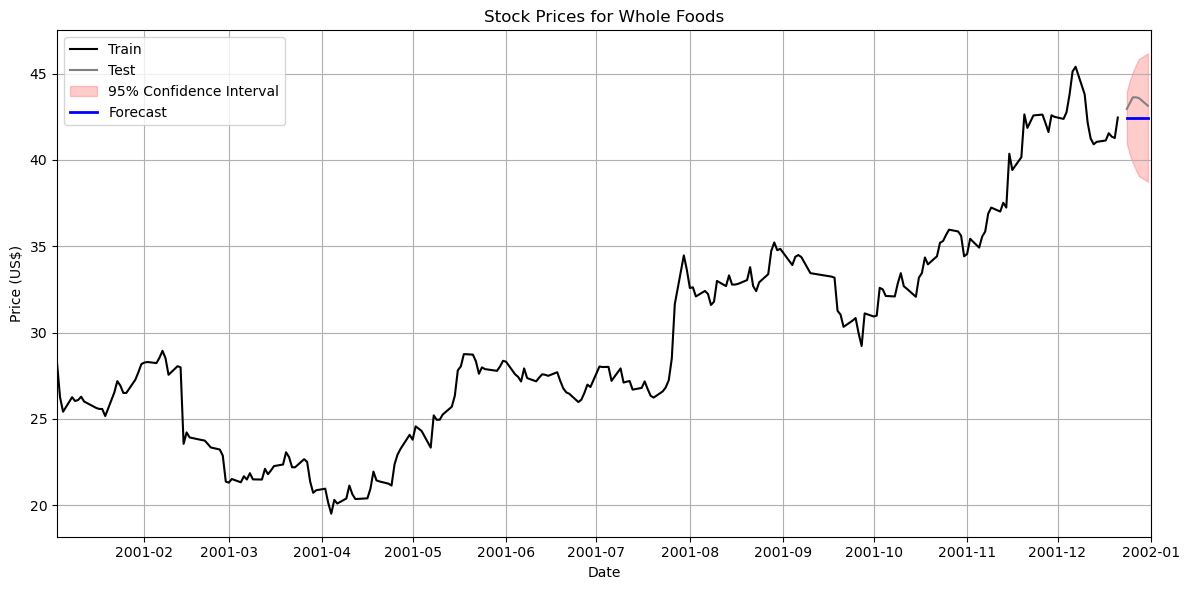

In [27]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(train.index, train['Price'], label='Train', color='black')
plt.plot(test.index, test['Price'], label='Test', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_resultm2.index,
                 conf_int_5m2.iloc[:, 0],     # Lower bound
                 conf_int_5m2.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_resultm2['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Stock Prices for Whole Foods')
plt.xlabel('Date')
plt.ylabel('Price (US$)')
plt.xlim(pd.to_datetime('2001-01-03'), pd.to_datetime('2002-01-01'))
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
# Forecast the next 5 time points
forecast_5m2 = model_fitM2.get_forecast(steps=6)

# Extract predicted mean
forecast_mean_5m2 = forecast_5m2.predicted_mean

# Extract confidence intervals
conf_int_5m3 = forecast_5m2.conf_int(alpha=0.20)   # for 80% confidence interval

# Get the last date from the original dataframe <====
last_date = train.index[-1]

# Create future dates for the forecast horizon <====
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=6, freq='B')  # 'B' = business day

# Reconstruct the forecast DataFrame with the correct index
forecast_resultm3 = pd.DataFrame({
    'Forecast': forecast_mean_5m2.values,
    'Lower 80% CI': conf_int_5m3.iloc[:, 0].values,
    'Upper 80% CI': conf_int_5m3.iloc[:, 1].values
}, index=forecast_index)

forecast_resultm3

,Forecast,Lower 80% CI,Upper 80% CI
2001-12-24,42.46,41.467337,43.452663
2001-12-25,42.46,41.056162,43.863838
2001-12-26,42.46,40.740656,44.179344
2001-12-27,42.46,40.474673,44.445327
2001-12-28,42.46,40.240337,44.679663
2001-12-31,42.46,40.028481,44.891519


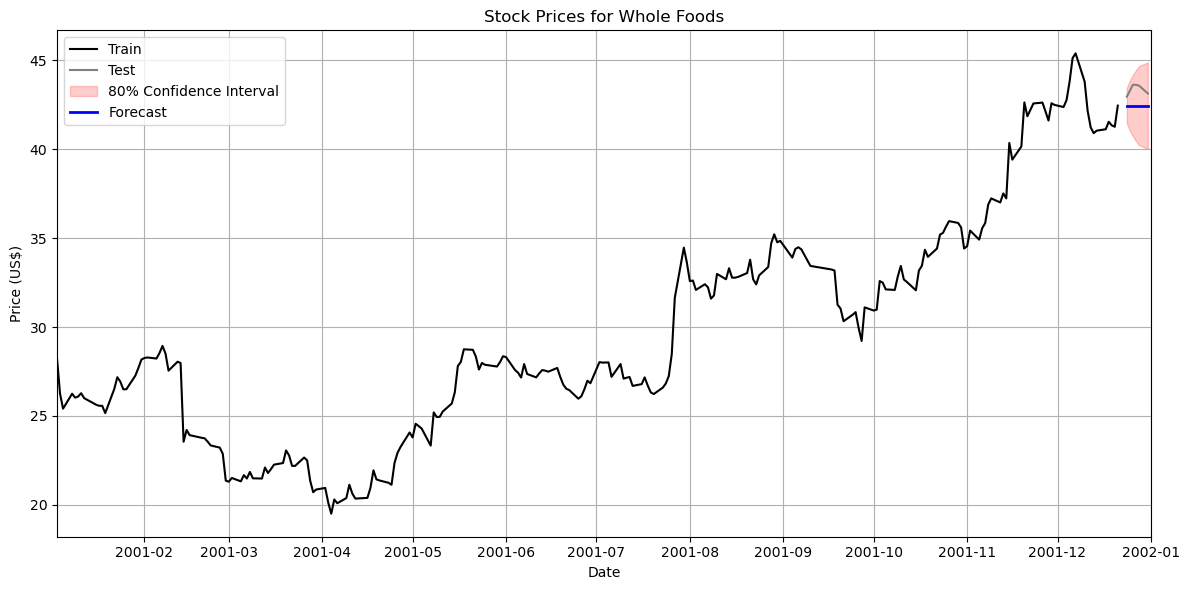

In [29]:
# Plot actual production and forecast with confidence intervals
plt.figure(figsize=(12, 6))

# Plot actual production values
plt.plot(train.index, train['Price'], label='Train', color='black')
plt.plot(test.index, test['Price'], label='Test', color='gray')

# Plot 95% confidence interval
plt.fill_between(forecast_resultm3.index,
                 conf_int_5m3.iloc[:, 0],     # Lower bound
                 conf_int_5m3.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='80% Confidence Interval')

# Plot forecasted values
plt.plot(forecast_resultm2['Forecast'],label='Forecast',color='blue',linewidth=2)

# Final formatting
plt.title('Stock Prices for Whole Foods')
plt.xlabel('Date')
plt.ylabel('Price (US$)')
plt.xlim(pd.to_datetime('2001-01-03'), pd.to_datetime('2002-01-01'))
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 5.20 Unemployment rate data is given in Table B.8. 
Develop an appropriate ARIMA model and a procedure for forecasting for these data.
Explain how prediction intervals would be computed.

In [30]:
from datetime import datetime
import pandas as pd
import re

# Raw text input (shortened for this example, but you would use the full text)
raw_text = '''
Jan-1963 6.8 Jan-1970 3.8 Jan-1977 7.9 Jan-1984 8.9 Jan-1991 7.0 Jan-1998 5.0
Feb-1963 6.8 Feb-1970 4.3 Feb-1977 8.2 Feb-1984 8.5 Feb-1991 7.4 Feb-1998 4.8
Mar-1963 6.2 Mar-1970 4.2 Mar-1977 7.6 Mar-1984 8.3 Mar-1991 7.1 Mar-1998 4.8
Apr-1963 5.6 Apr-1970 4.1 Apr-1977 6.7 Apr-1984 7.8 Apr-1991 6.6 Apr-1998 4.0
May-1963 5.4 May-1970 4.2 May-1977 6.4 May-1984 7.4 May-1991 6.7 May-1998 4.2
Jun-1963 6.0 Jun-1970 5.5 Jun-1977 7.3 Jun-1984 7.4 Jun-1991 7.0 Jun-1998 4.6
Jul-1963 5.4 Jul-1970 5.1 Jul-1977 6.9 Jul-1984 7.6 Jul-1991 6.9 Jul-1998 4.6
Aug-1963 4.9 Aug-1970 4.7 Aug-1977 6.6 Aug-1984 7.2 Aug-1991 6.5 Aug-1998 4.3
Sep-1963 4.3 Sep-1970 4.5 Sep-1977 6.0 Sep-1984 6.8 Sep-1991 6.3 Sep-1998 4.1
Oct-1963 4.4 Oct-1970 4.5 Oct-1977 5.9 Oct-1994 6.9 Oct-1991 6.3 Oct-1998 3.9
Nov-1963 4.9 Nov-1970 4.9 Nov-1977 5.9 Nov-1984 6.8 Nov-1991 6.6 Nov-1998 3.8
Dec-1963 5.1 Dec-1970 5.2 Dec-1977 5.7 Dec-1984 7.1 Dec-1991 7.0 Dec-1998 3.9
Jan-1964 6.2 Jan-1971 6.1 Jan-1978 6.7 Jan-1985 8.0 Jan-1992 8.1 Jan-1999 4.6
Feb-1964 6.1 Feb-1971 6.2 Feb-1978 6.6 Feb-1985 7.9 Feb-1992 8.3 Feb-1999 4.6
Mar-1964 5.7 Mar-1971 5.9 Mar-1978 6.2 Mar-1985 7.5 Mar-1992 7.9 Mar-1999 4.3
Apr-1964 5.1 Apr-1971 5.4 Apr-1978 5.5 Apr-1985 7.1 Apr-1992 7.4 Apr-1999 4.0
May-1964 4.7 May-1971 5.2 May-1978 5.5 May-1985 7.0 May-1992 7.4 May-1999 3.9
Jun-1964 5.7 Jun-1971 6.4 Jun-1978 6.1 Jun-1985 7.5 Jun-1992 8.0 Jun-1999 4.3
Jul-1964 4.7 Jul-1971 6.0 Jul-1978 6.1 Jul-1985 7.4 Jul-1992 7.8 Jul-1999 4.4
Aug-1964 4.5 Aug-1971 5.6 Aug-1978 5.5 Aug-1985 6.8 Aug-1992 7.3 Aug-1999 4.1
Sep-1964 4.0 Sep-1971 5.1 Sep-1978 5.1 Sep-1985 6.6 Sep-1992 7.0 Sep-1999 3.8
Oct-1964 4.0 Oct-1971 4.8 Oct-1978 4.8 Oct-1985 6.5 Oct-1992 6.7 Oct-1999 3.7
Nov-1964 4.0 Nov-1971 5.1 Nov-1978 5.0 Nov-1986 6.6 Nov-1992 7.0 Nov-1999 3.6
Dec-1964 4.3 Dec-1971 5.2 Dec-1978 5.2 Dec-1985 6.6 Dec-1992 7.1 Dec-1999 3.7
Jan-1965 5.3 Jan-1972 6.1 Jan-1979 5.9 Jan-1986 7.3 Jan-1993 7.9 Jan-2000 4.3
Feb-1965 5.5 Feb-1972 6.0 Feb-1979 6.1 Feb-1986 7.8 Feb-1993 7.9 Feb-2000 4.2
Mar-1965 4.9 Mar-1972 5.8 Mar-1979 5.7 Mar-1986 7.5 Mar-1993 7.5 Mar-2000 4.1
Apr-1965 4.5 Apr-1972 5.2 Apr-1979 5.3 Apr-1986 7.0 Apr-1993 6.9 Apr-2000 3.5
May-1965 4.1 May-1972 5.1 May-1979 5.0 May-1986 7.1 May-1993 6.9 May-2000 3.7
Jun-1965 5.1 Jun-1972 6.0 Jun-1979 5.9 Jun-1986 7.3 Jun-1993 7.2 Jun-2000 4.0
Jul-1965 4.2 Jul-1972 5.7 Jul-1979 5.7 Jul-1986 7.0 Jul-1993 7.1 Jul-2000 4.0
Aug-1965 3.9 Aug-1972 5.2 Aug-1979 5.5 Aug-1986 6.4 Aug-1993 6.5 Aug-2000 3.9
Sep-1965 3.4 Sep-1972 4.6 Sep-1979 5.1 Sep-1986 6.5 Sep-1993 6.2 Sep-2000 3.5
Oct-1965 3.2 Oct-1972 4.5 Oct-1979 5.1 Oct-1986 6.3 Oct-1993 6.1 Oct-2000 3.5
Nov-1965 3.3 Nov-1972 4.2 Nov-1979 5.2 Nov-1986 6.4 Nov-1993 6.0 Nov-2000 3.5
Dec-1965 3.4 Dec-1972 4.2 Dec-1979 5.3 Dec-1986 6.3 Dec-1993 6.2 Dec-2000 3.6
Jan-1966 4.1 Jan-1973 5.1 Jan-1980 6.5 Jan-1987 7.2 Jan-1994 7.5 Jan-2001 4.5
Feb-1966 4.0 Feb-1973 5.2 Feb-1980 6.5 Feb-1987 7.1 Feb-1994 7.4 Feb-2001 4.4
Mar-1966 3.8 Mar-1973 4.9 Mar-1980 6.4 Mar-1987 6.7 Mar-1994 7.0 Mar-2001 4.4
Apr-1966 3.5 Apr-1973 4.4 Apr-1980 6.6 Apr-1987 6.1 Apr-1994 6.3 Apr-2001 4.0
May-1966 3.4 May-1973 4.2 May-1980 7.2 May-1987 6.1 May-1994 5.9 May-2001 4.1
Jun-1966 4.3 Jun-1973 5.1 Jun-1980 8.0 Jun-1987 6.4 Jun-1994 6.3 Jun-2001 4.6
Jul-1966 3.7 Jul-1973 4.7 Jul-1980 8.1 Jul-1987 6.1 Jul-1994 6.4 Jul-2001 4.6
Aug-1966 3.2 Aug-1973 4.3 Aug-1980 7.6 Aug-1987 5.6 Aug-1994 5.8 Aug-2001 4.7
Sep-1966 2.9 Sep-1973 3.9 Sep-1980 6.9 Sep-1987 5.3 Sep-1994 5.5 Sep-2001 4.7
Oct-1966 2.8 Oct-1973 3.6 Oct-1980 6.8 Oct-1987 5.3 Oct-1994 5.3 Oct-2001 4.9
Nov-1966 3.0 Nov-1973 4.0 Nov-1980 7.0 Nov-1987 5.4 Nov-1994 5.2 Nov-2001 5.2
Dec-1966 3.1 Dec-1973 4.1 Dec-1980 7.0 Dec-1987 5.3 Dec-1994 5.0 Dec-2001 5.5
Jan-1967 3.8 Jan-1974 5.2 Jan-1981 8.0 Jan-1988 6.1 Jan-1995 6.1 Jan-2002 6.5
Feb-1967 3.6 Feb-1974 5.3 Feb-1981 8.0 Feb-1988 6.1 Feb-1995 5.8 Feb-2002 6.3
Mar-1967 3.5 Mar-1974 5.0 Mar-1981 7.6 Mar-1988 5.8 Mar-1995 5.7 Mar-2002 6.2
Apr-1967 3.2 Apr-1974 4.6 Apr-1981 7.0 Apr-1988 5.2 Apr-1995 5.5 Apr-2002 5.9
May-1967 3.0 May-1974 4.5 May-1981 7.2 May-1988 5.4 May-1995 5.4 May-2002 5.7
Jun-1967 4.3 Jurv1974 5.6 Jun-1981 7.8 Jun-1988 5.4 Jun-1995 5.7 Jun-2002 5.2
Jul-1967 3.7 Jul-1974 5.4 Jul-1981 7.4 Jul-1988 5.4 Jul-1995 5.8 Jul-2002 6.0
Aug-1967 3.4 Aug-1974 4.9 Aug-1981 7.0 Aug-1988 5.2 Aug-1995 5.5 Aug-2002 5.6
Sep-1967 3.1 Sep-1974 4.9 Sep-1981 6.9 Sep-1988 4.8 Sep-1995 5.2 Sep-2002 5.3
Oct-1967 3.1 Oct-1974 5.0 Oct-1981 7.3 Oct-1988 4.7 Oct-1995 5.0 Oct-2002 5.4
Nov-1967 3.0 Nov-1974 5.7 Nov-1981 7.8 Nov-1988 4.9 Nov-1995 5.1 Nov-2002 5.7
Dec-1967 3.0 Dec-1974 6.3 Dec-1981 8.5 Dec-1988 5.0 Dec-1995 5.2 Dec-2002 5.9
Jan-1968 3.7 Jan-1975 8.7 Jan-1982 9.5 Jan-1989 5.7 Jan-1996 6.2 Jan-2003 6.6
Feb-1968 3.8 Feb-1975 9.0 Feb-1982 9.6 Feb-1989 5.5 Feb-1996 5.9 Feb-2003 6.5
Mar-1968 3.4 Mar-1975 9.1 Mar-1982 9.7 Mar-1989 5.2 Mar-1996 5.8 Mar-2003 6.3
Apr-1968 2.9 Apr-1975 8.7 Apr-1982 9.4 Apr-1989 5.0 Apr-1996 5.3 Apr-2003 6.0
May-1968 2.7 May-1975 8.6 May-1982 9.5 May-1989 5.0 May-1996 5.3 May-2003 6.0
Jun-1968 4.2 Jun-1975 9.3 Jun-1982 10.3 Jun-1989 5.3 Jun-1996 5.4 Jun-2003 6.6
Jul-1968 3.7 Jul-1975 8.7 Jul-1982 10.1 Jul-1989 5.3 Jul-1996 5.6 Jul-2003 6.4
Aug-1966 3.1 Aug-1975 7.9 Aug-1982 9.8 Aug-1989 4.9 Aug-1996 4.9 Aug-2003 6.1
Sep-1968 2.7 Sep-1975 7.6 Sep-1982 9.7 Sep-1969 4.7 Sep-1996 4.8 Sep-2003 5.7
Oct-1968 2.7 Oct-1975 7.4 Oct-1982 10.1 Oct-1969 4.6 Oct-1996 4.7 Oct-2003 5.6
Nov-1968 2.6 Nov-1975 7.5 Nov-1962 10.6 Nov-1989 4.9 Nov-1996 4.9 Nov-2003 5.7
Dec-1968 2.5 Dec-1975 7.5 Dec-1962 11.0 Dec-1989 4.9 Dec-1996 4.9 Dec-2003 5.6
Jan-1969 3.3 Jan-1976 8.6 Jan-1983 11.9 Jan-1990 5.8 Jan-1997 5.8 Jan-2004 6.3
Feb-1969 3.3 Feb-1976 8.4 Feb-1983 11.9 Feb-1990 5.6 Feb-1997 5.5 Feb-2004 6.1
Mar-1969 3.1 Mar-1976 8.0 Mar-1983 11.4 Mar-1990 5.4 Mar-1997 5.4 Mar-2004 6.2
Apr-1969 2.9 Apr-1976 7.2 Apr-1983 10.6 Apr-1990 5.2 Apr-1997 4.7 Apr-2004 5.4
May-1969 2.7 May-1976 6.8 May-1983 10.3 May-1990 5.1 May-1997 4.7 May-2004 5.5
Jun-1969 4.0 Jun-1976 8.1 Jun-1983 10.6 Jun-1990 5.3 Jun-1997 5.1 Jun-2004 5.8
Jul-1969 3.6 Jul-1976 7.6 Jul-1983 9.8 Jul-1990 5.4 JuL-1997 5.0 Jul-2004 5.8
Aug-1969 3.1 Aug-1976 7.3 Aug-1983 9.4 Aug-1990 5.2 Aug-1997 4.6 Aug-2004 5.3
Sep-1969 3.0 Sep-1976 6.9 Sep-1983 8.8 Sep-1990 5.3 Sep-1997 4.5 Sep-2004 5.1
Oct-1969 2.8 Oct-1976 6.7 Oct-1983 8.4 Oct-1990 5.2 Oct-1997 4.2 Oct-2004 5.0
Nov-1969 2.7 Nov-1976 7.0 Nov-1983 8.2 Nov-1990 5.7 Nov-1997 4.1 Nov-2004 5.1
Dec-1969 2.8 Dec-1976 7.2 Dec-1983 6.2 Dec-1990 6.0 Dec-1997 4.3 Dec-2004 5.2
'''

# Extract (date, value) pairs using regex
pattern = r'([A-Za-z]{3}-\d{4})\s+(\d+\.\d+)'
matches = re.findall(pattern, raw_text)

# Convert to DataFrame
data = [(datetime.strptime(date, '%b-%Y'), float(value)) for date, value in matches]
df_unemp = pd.DataFrame(data, columns=['Date', 'Unemp Rate']).set_index('Date').sort_index()

# Move the rows into a proper chronological order
df_unemp.sort_index(inplace=True)

df_unemp

,Unemp Rate
Date,
1962-11-01,10.6
1962-12-01,11.0
1963-01-01,6.8
1963-02-01,6.8
1963-03-01,6.2
...,...
2004-08-01,5.3
2004-09-01,5.1
2004-10-01,5.0


In [31]:
# Check if there are any duplicated index values
df.index.duplicated().any()

False

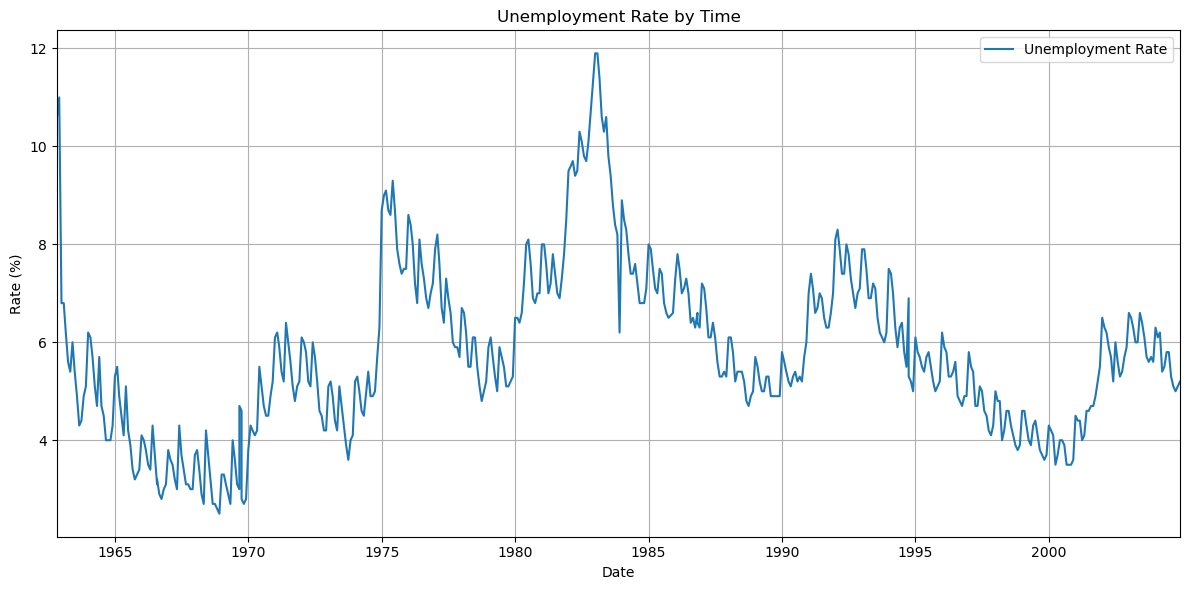

In [32]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_unemp.index, df_unemp['Unemp Rate'], label='Unemployment Rate')     # Actual

plt.title('Unemployment Rate by Time')                      
plt.xlabel('Date')                                        
plt.ylabel('Rate (%)')  
plt.xlim(pd.to_datetime('1962-11-01'), pd.to_datetime('2004-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();   

In [33]:
# Split the data into train and test
train = df_unemp.iloc[:-20]       # All rows except the last 5
test = df_unemp.iloc[-20:]        # Last 5 rows

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (483, 1)
Test shape: (20, 1)


In [34]:
unemp_series = train['Unemp Rate']

In [35]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(unemp_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.6168
p-value: 0.0896

p-value > alpha; H0: Not Stationary


In [36]:
# Difference the series if non-stationary
diff_series = unemp_series.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -5.0545
p-value: 0.0000

p-value < alpha; Ha: Stationary


    d = 1

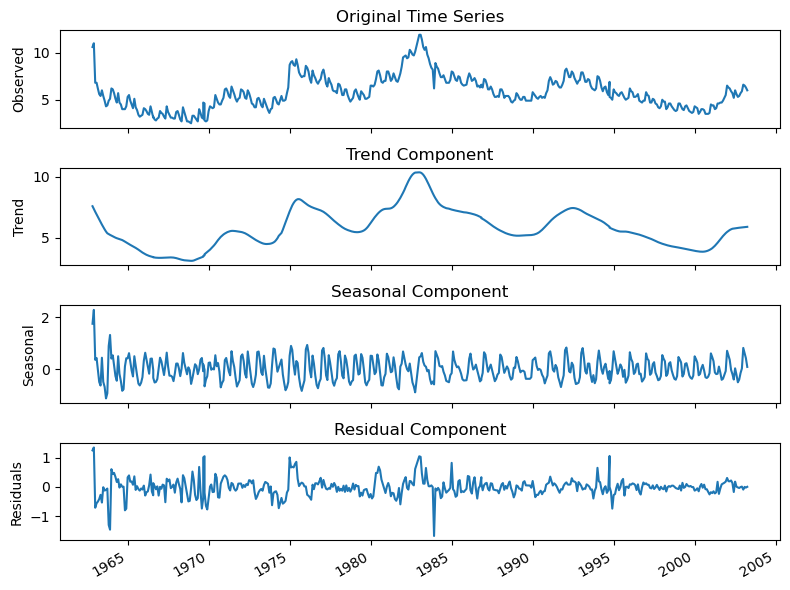

In [37]:
unemp_series = train['Unemp Rate']

decom_unemp = STL(unemp_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_unemp.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_unemp.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_unemp.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_unemp.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [38]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decom_unemp.seasonal)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -16.7898
p-value: 0.0000

p-value < alpha; Ha: Stationary


In [39]:
# Define the seasonal periods to test (2 to 10)
seasonal_periods = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Loop over seasonal periods and run the Canova-Hansen test
for S in seasonal_periods:
    print(f"Testing with seasonal period = {S}")
    
    ch_test = CHTest(m=S)   # Initialize the CHTest with the seasonal period

    D = ch_test.estimate_seasonal_differencing_term(unemp_series) # Estimate seasonal differencing term
    
    print(f"Suggested seasonal differencing term (D): {D}\n")

Testing with seasonal period = 2
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 3
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 4
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 5
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 6
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 7
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 8
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 9
Suggested seasonal differencing term (D): 0

Testing with seasonal period = 10
Suggested seasonal differencing term (D): 0



In [40]:
# Perform a full grid search for ARIMA model only (non-seasonal)
auto_model_arima = pm.auto_arima(
    unemp_series,               # Time series data
    seasonal=False,             # Disable seasonal component (ARIMA only)
    d=1,                        # Set non-seasonal differencing
    start_p=0, max_p=3,         # p range: 0 to 3
    start_q=0, max_q=3,         # q range: 0 to 3
    stepwise=False,             # Full grid search
    trace=True,                 # Print model search process
    error_action='ignore',      # Skip models that fail
    suppress_warnings=True,     # Hide convergence warnings
    information_criterion='aic' # Use AIC to rank models
)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=799.135, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=800.965, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=791.794, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=771.343, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=801.008, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=802.491, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=785.276, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=773.340, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=793.505, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=780.355, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=729.915, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=765.981, Time=0.58 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=768.270, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=769.786, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=731.875, Time=0.40 sec

Best model:  ARIMA(2,1,2

In [41]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


pv, qv = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
dv = [1]                         # Set non-seasonal differencing

vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations

    print(f'Running model #{i} using ARIMA({p},{d},{q})')
    
    m = ARIMA(unemp_series, order=(p,d,q))  # Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'model': res                        # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()  

Running model #0 using ARIMA(0,1,0)
Running model #1 using ARIMA(0,1,1)
Running model #2 using ARIMA(0,1,2)
Running model #3 using ARIMA(0,1,3)
Running model #4 using ARIMA(1,1,0)
Running model #5 using ARIMA(1,1,1)
Running model #6 using ARIMA(1,1,2)
Running model #7 using ARIMA(1,1,3)
Running model #8 using ARIMA(2,1,0)
Running model #9 using ARIMA(2,1,1)
Running model #10 using ARIMA(2,1,2)
Running model #11 using ARIMA(2,1,3)
Running model #12 using ARIMA(3,1,0)
Running model #13 using ARIMA(3,1,1)
Running model #14 using ARIMA(3,1,2)
Running model #15 using ARIMA(3,1,3)



,index,order,AIC,AICc,model
0,10,"(2, 1, 2)",728.116191,728.242242,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(3, 1, 2)",730.073897,730.250739,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,15,"(3, 1, 3)",759.093823,759.33011,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,11,"(2, 1, 3)",764.157267,764.334109,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,12,"(3, 1, 0)",766.436301,766.520159,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [42]:
unemp_series = train['Unemp Rate']

# Define the ARIMA model structure
modelMU = ARIMA(endog=unemp_series,
                order=(2, 1, 2))

# Fit the model
model_fitMU = modelMU.fit()

# Display Summary
print(model_fitMU.summary())

                               SARIMAX Results                                
Dep. Variable:             Unemp Rate   No. Observations:                  483
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -359.058
Date:                Fri, 04 Apr 2025   AIC                            728.116
Time:                        13:52:47   BIC                            749.006
Sample:                             0   HQIC                           736.326
                                - 483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0110      0.020     51.823      0.000       0.973       1.049
ar.L2         -0.9613      0.015    -64.193      0.000      -0.991      -0.932
ma.L1         -1.0919      0.026    -41.265      0.0

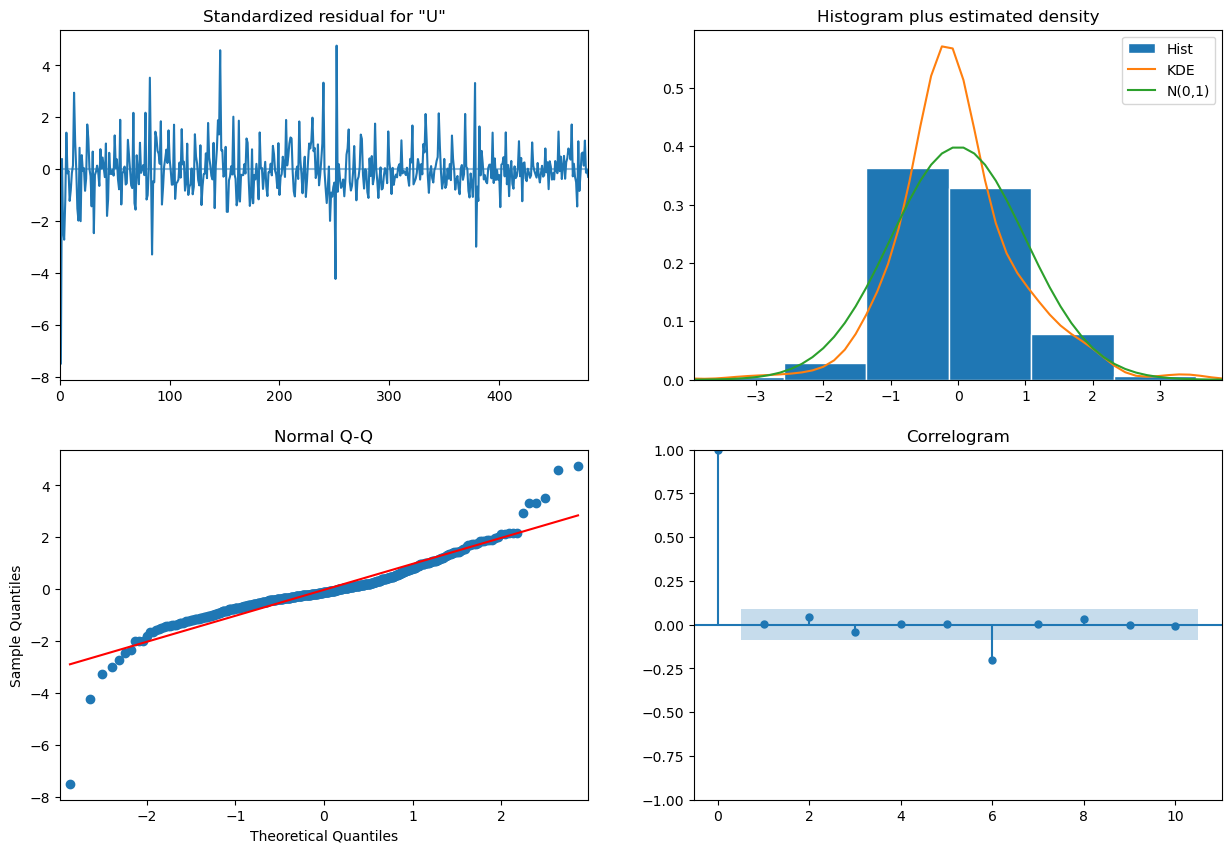

In [43]:
# Plots diagnostic checks for the fitted ARIMA model
model_fitMU.plot_diagnostics(figsize=(15,10))
plt.show()

In [44]:
# Extract the residuals (errors) from the fitted model
residuals = model_fitMU.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,0.186158,0.666133
2,12.408733,0.002021
3,12.456438,0.005972
4,13.845329,0.007805
5,15.887563,0.007173
6,24.403066,0.000440
7,25.069915,0.000737
8,25.161645,0.001459
9,25.164773,0.002794
10,25.711668,0.004148


In [45]:
# Forecast the next 20 time points
forecast_20 = model_fitMU.get_forecast(steps=20)

# Extract predicted mean and confidence intervals
forecast_mean_20 = forecast_20.predicted_mean
conf_int_20 = forecast_20.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_20.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Unemp Rate']

test['Lower 95% CI'] = conf_int_20.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_20.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Unemp Rate,Forecast,Error,Lower 95% CI,Upper 95% CI
Date,,,,,
2003-05-01,6.0,6.038625,0.038625,5.041521,7.035729
2003-06-01,6.6,6.230138,-0.369862,4.875913,7.584363
2003-07-01,6.4,6.386619,-0.013381,4.819194,7.954044
2003-08-01,6.1,6.360705,0.260705,4.628082,8.093328
2003-09-01,5.7,6.184074,0.484074,4.271839,8.096308
2003-10-01,5.6,6.030418,0.430418,3.904215,8.156621
2003-11-01,5.7,6.044882,0.344882,3.702307,8.387457
2003-12-01,5.6,6.207221,0.607221,3.689785,8.724657
2004-01-01,6.3,6.357436,0.057436,3.713493,9.001378


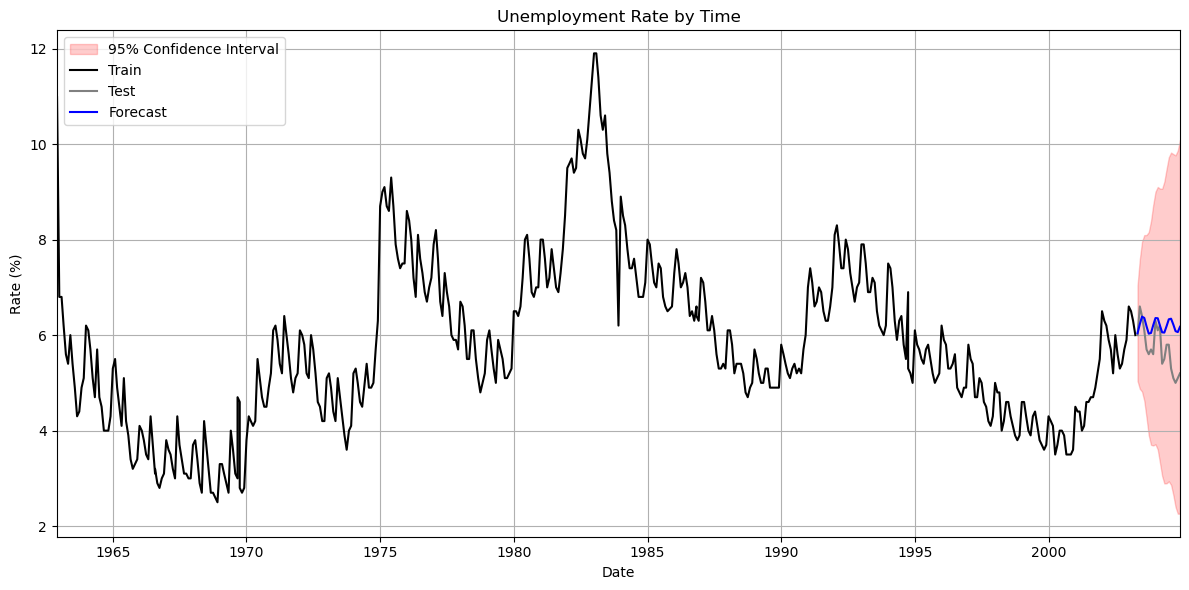

In [46]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_20.iloc[:, 0],     # Lower bound
                 conf_int_20.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Unemp Rate'], label='Train', color='black')  # Train
plt.plot(test.index, test['Unemp Rate'], label='Test', color='gray')      # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Unemployment Rate by Time')                         
plt.xlabel('Date')                                        
plt.ylabel('Rate (%)') 
plt.xlim(pd.to_datetime('1962-12-01'), pd.to_datetime('2004-12-01'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();  

In [47]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Unemp Rate']).mean() * 100

# Print the result
print(f"MAPE (0,1,0)(0,0,0): {mape:.2f}%")

MAPE (0,1,0)(0,0,0): 9.40%


## 5.22 Table B.9 contains yearly data on the international sunspot numbers. 
Develop an appropriate ARIMA model and a procedure for
forecasting for these data. Explain how prediction intervals would
be computed.

In [48]:
# Raw data copied from the prompt
raw_data = """
1700 5.1 1761 86 1622 4.1 1883 63.8 1944 9.7 1701 11.1 1762 61.3 1623 1.9 1884 63.6 1945 33.3 1702 16.1 1763 45.2 1824 8.6 1885 52.3 1946 92.7
1703 23.1 1764 36.5 1825 16.7 1886 25.5 1947 151.7 1704 36.1 1765 21 1826 36.4 1887 13.2 1948 136.4 1705 58.1 1766 11.5 1827 49.7 1888 6.9 1949 134.8
1706 29.1 1767 37.9 1828 64.3 1889 64 1950 84 1707 20.1 1768 69.9 1829 67.1 1890 7.2 1951 69.5 1708 10.1 1769 106.2 1830 71 1891 35.7 1952 31.6
1709 8.1 1770 100.9 1831 47.9 1892 73.1 1953 14 1710 3.1 1771 81.7 1832 27.6 1893 85.2 1954 4.5 1711 0.1 1772 66.6 1833 8.6 1894 78.1 1955 38.1
1712 0.1 1773 34.9 J834 13.3 1895 64.1 1956 141 .8 1713 2.1 1774 30.7 1835 57 1896 41 .9 1957 190.3 1714 11.1 1775 7.1 1836 121.6 1897 26.3 1958 184.9
1715 27.1 1776 19.9 1837 138.4 1898 26.8 1959 159.1 1716 47.1 1777 92.6 1838 103.3 1899 12.2 1960 112.4 1717 63.1 1778 154. 5 1839 85.8 1900 9.6 1961 54
1718 60.1 1779 126 1840 64.7 1901 2.8 1962 37.7 1719 39.1 1780 84.9 1841 36.8 1902 5.1 1963 28 1720 28.1 1781 68.2 1842 24.3 1903 24.5 1964 10.3
1721 26.1 1782 38.6 1843 10.8 1904 42.1 1965 152 1722 22.1 1783 22.9 1844 15.1 1905 63.6 1966 47.1 1723 11.1 1784 10.3 1845 40.2 1906 53.9 1967 93.8
1724 21.1 1785 24.2 1846 61.6 1907 62.1 1966 106 1725 40.1 1786 83 1847 98.6 1908 48.6 1969 105.6 1726 78.1 1787 132.1 1848 124. 8 1909 44 1970 104.6
1727 122.1 1788 131 1849 96.4 1910 18.7 1971 66.7 1728 103.1 1789 118.2 1850 66.7 1911 5.8 1972 69 1729 73.1 1790 90 1851 64.6 1912 3.7 1973 38.1
1730 47.1 1791 66.7 1852 54.2 1913 1.5 1974 34.6 1731 35.1 1792 60.1 1853 39.1 1914 9.7 1975 15.6 1732 11.1 1793 47 1854 20.7 1915 47.5 1976 12.7
1733 5.1 1794 41.1 1855 6.8 1916 57.2 1977 27.6 1734 16.1 1795 21.4 1856 4.4 1917 104 1978 92.6 1735 34.1 1796 16.1 1857 22.8 1918 80.7 1979 155.5
1736 70.1 1797 6.5 1858 54.9 1919 63.7 1980 154.7 1737 81.1 1798 4.2 1859 93.9 1920 37.7 1981 140.6 1738 111.1 1799 6.9 1860 95.9 1921 26.2 1982 116
1739 101.1 1800 14. 6 1861 77.3 1922 14.3 1983 66.7 1740 73.1 1801 34.1 1862 59.2 1923 59 1984 46 1741 40.1 1802 45.1 1863 44.1 1924 16.8 1985 18
1742 20.1 1803 43.2 1864 47.1 1925 44.4 1986 13.5 1743 16.1 1804 47.6 1865 30.6 1926 64 1987 29.3 1744 5.1 1805 42.3 1866 16.4 1927 69.1 1988 100.3
1745 11.1 1606 28.2 1867 7.4 1928 77.9 1989 157.7 1746 22.1 1807 10.2 1868 37.7 1929 65 1990 142.7 1747 40.1 1808 8.2 1869 74.1 1930 35.8 1991 145.8
1748 60.1 1809 2.6 1870 139.1 1931 21.3 1992 94.4 1749 81 1810 0.1 1871 111.3 1932 11.2 1993 54.7 1750 83.5 1811 1.5 1872 101.7 1933 5.8 1994 30
1751 47.8 1812 5.1 1873 66.3 1934 8.8 1995 17.6 1752 47.9 1813 12.3 1874 44.8 1935 36.2 1996 8.7 1753 30.8 1814 14 1875 17.1 1936 79.8 1997 21.6
1754 12.3 1815 35.5 1876 11.4 1937 114.5 1998 64.4 1755 9.7 1816 45.9 1877 12.5 1938 109.7 1999 93.4 1756 10.3 1817 41.1 1878 3.5 1939 88.9 2000 119.7
1757 32.5 1818 30.2 1879 6.1 1940 67.9 2001 111.1 1758 47.7 1819 24 1880 32.4 1941 47.6 2002 104.1 1759 54.1 1620 15.7 1881 54.4 1942 30.7 2003 63.8
1760 63 1821 6.7 1882 59.8 1943 16.4 2004 40.5
"""

# Flatten the data into year-number pairs
entries = re.findall(r'(\d{4})\s+([\d.]+)', raw_data)

# Create DataFrame
df_sunspots = pd.DataFrame(entries, columns=['Year', 'Number'])
df_sunspots['Year'] = df_sunspots['Year'].astype(int)
df_sunspots['Number'] = df_sunspots['Number'].astype(float)
df_sunspots.set_index('Year', inplace=True)
df_sunspots.sort_index(inplace=True)

df_sunspots.head(10)

,Number
Year,
1606,28.2
1620,15.7
1622,4.1
1623,1.9
1700,5.1
1701,11.1
1702,16.1
1703,23.1
1704,36.1


In [49]:
df_sunspots = df_sunspots.iloc[4:] # Drop first 4 rows
df_sunspots.head(10)

,Number
Year,
1700,5.1
1701,11.1
1702,16.1
1703,23.1
1704,36.1
1705,58.1
1706,29.1
1707,20.1
1708,10.1


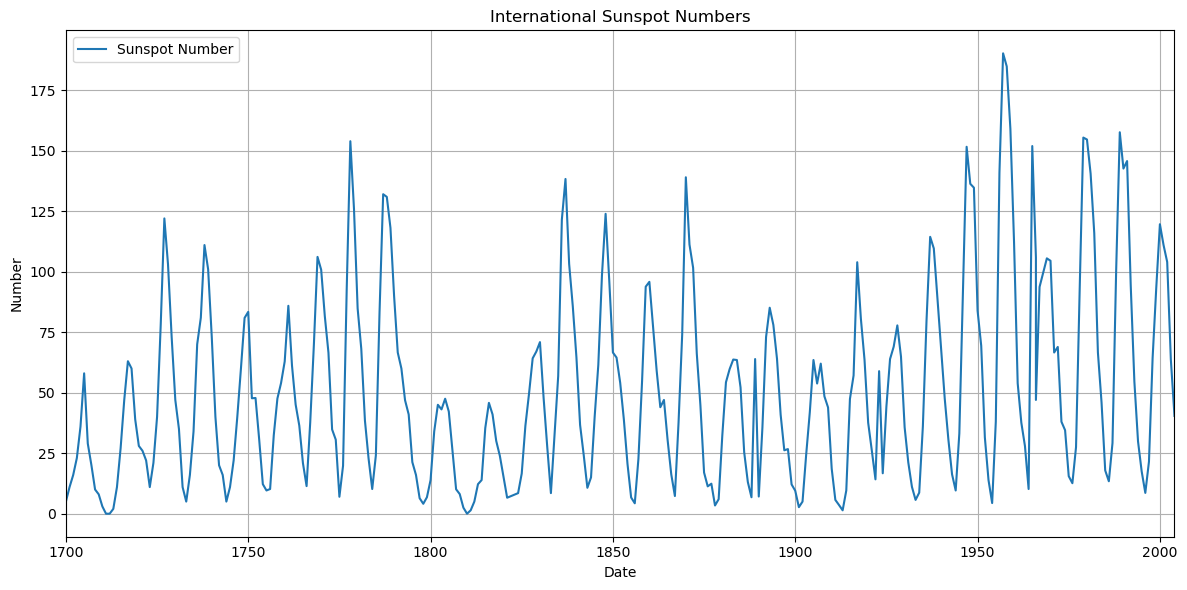

In [50]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_sunspots.index, df_sunspots['Number'], label='Sunspot Number')     # Actual

plt.title('International Sunspot Numbers')                      
plt.xlabel('Date')                                        
plt.ylabel('Number')  
plt.xlim(1700, 2004)
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();   

In [51]:
# Split the data into train and test
suntrain = df_sunspots.iloc[:-20]       # All rows except the last 5
suntest = df_sunspots.iloc[-20:]        # Last 5 rows

# Show results
print("Train shape:", suntrain.shape)
print("Test shape:", suntest.shape)

Train shape: (280, 1)
Test shape: (20, 1)


In [52]:
sunspots_series = suntrain['Number']

In [53]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(sunspots_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.8860
p-value: 0.0470

p-value < alpha; Ha: Stationary


    d = 0

In [54]:
# Define the seasonal periods to test (2 to 50 inclusive)
seasonal_periods = list(range(2, 51))

# Loop over seasonal periods and run the Canova-Hansen test
for S in seasonal_periods:
    
    ch_test = CHTest(m=S)   # Initialize the CHTest with the seasonal period

    D = ch_test.estimate_seasonal_differencing_term(sunspots_series) # Estimate seasonal differencing term

    if D != 0:
        print(f"Testing with seasonal period = {S}")
        print(f"Suggested seasonal differencing term (D): {D}")

print('ALL D values are equal to 0.')

ALL D values are equal to 0.


    No seasonal component.

In [55]:
# Perform a full grid search for ARIMA model only (non-seasonal)
auto_model_arima = pm.auto_arima(
    sunspots_series,            # Time series data
    seasonal=False,             # Disable seasonal component (ARIMA only)
    d=0,                        # Set non-seasonal differencing
    start_p=0, max_p=3,         # p range: 0 to 3
    start_q=0, max_q=3,         # q range: 0 to 3
    stepwise=False,             # Full grid search
    trace=True,                 # Print model search process
    error_action='ignore',      # Skip models that fail
    suppress_warnings=True,     # Hide convergence warnings
    information_criterion='aic' # Use AIC to rank models
)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3126.718, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2853.399, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2705.848, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2642.423, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2616.752, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2580.505, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2575.871, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2571.465, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2573.753, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2575.700, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2559.098, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2577.308, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2575.668, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2577.306, Time=0.26 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2488.388, Time=0.29 sec

Best mode

In [56]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


pv, qv = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
dv = [0]                         # Set non-seasonal differencing

vals = combinator([pv, dv, qv])             # Generate all possible combinations of (p,d,q) using a custom combinator function

score = {}                                  # Initialize dictionary to store evaluation metrics for each model

for i, (p, d, q) in enumerate(vals):        # Iterate over all (p,d,q) combinations

    print(f'Running model #{i} using ARIMA({p},{d},{q})')
    
    m = ARIMA(sunspots_series, order=(p,d,q))  # Create an ARIMA model with current parameters
    res = m.fit()                           # Fit the model to the training data
    
    score[i] = {                            # Store results in the dictionary
        'order': (p,d,q),                   # ARIMA order
        'AIC': res.aic,                     # Akaike Information Criterion
        'AICc': res.aicc,                   # Corrected AIC
        'model': res                        # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()  

Running model #0 using ARIMA(0,0,0)
Running model #1 using ARIMA(0,0,1)
Running model #2 using ARIMA(0,0,2)
Running model #3 using ARIMA(0,0,3)
Running model #4 using ARIMA(1,0,0)
Running model #5 using ARIMA(1,0,1)
Running model #6 using ARIMA(1,0,2)
Running model #7 using ARIMA(1,0,3)
Running model #8 using ARIMA(2,0,0)
Running model #9 using ARIMA(2,0,1)
Running model #10 using ARIMA(2,0,2)
Running model #11 using ARIMA(2,0,3)
Running model #12 using ARIMA(3,0,0)
Running model #13 using ARIMA(3,0,1)
Running model #14 using ARIMA(3,0,2)
Running model #15 using ARIMA(3,0,3)



,index,order,AIC,AICc,model
0,15,"(3, 0, 3)",2482.124727,2482.656092,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,11,"(2, 0, 3)",2510.652563,2511.064328,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,9,"(2, 0, 1)",2515.641517,2515.860496,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,12,"(3, 0, 0)",2516.254146,2516.473124,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,10,"(2, 0, 2)",2516.518297,2516.825989,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [57]:
# Define the ARIMA model structure
model3 = ARIMA(endog=sunspots_series,
                order=(3, 0, 3))

# Fit the model
model_fit3 = model3.fit()

# Display Summary
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                 Number   No. Observations:                  280
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1233.062
Date:                Fri, 04 Apr 2025   AIC                           2482.125
Time:                        13:52:52   BIC                           2511.203
Sample:                             0   HQIC                          2493.788
                                - 280                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3458      7.888      6.383      0.000      34.886      65.806
ar.L1          2.5143      0.044     56.997      0.000       2.428       2.601
ar.L2         -2.3777      0.070    -33.970      0.0

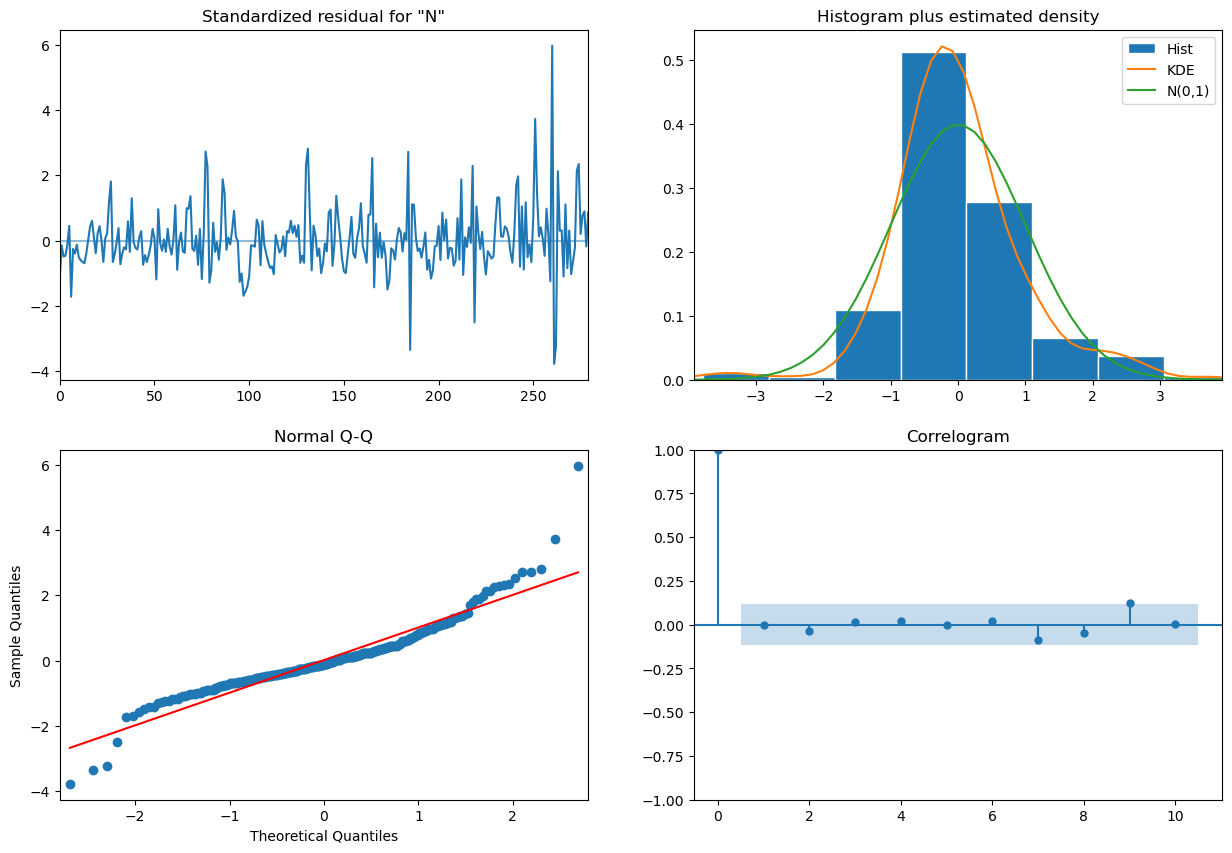

In [58]:
# Plots diagnostic checks for the fitted ARIMA model
model_fit3.plot_diagnostics(figsize=(15,10))
plt.show()

In [59]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit3.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.000916,0.975858
2,0.287957,0.865906
3,0.373571,0.945646
4,0.541481,0.969339
5,0.547939,0.990263
6,0.821753,0.991478
7,2.866323,0.897087
8,3.436614,0.904053
9,7.827046,0.551666
10,7.837593,0.644697


In [60]:
# Forecast the next 20 time points
forecast_20 = model_fit3.get_forecast(steps=20)

# Extract predicted mean and confidence intervals
forecast_mean_20 = forecast_20.predicted_mean
conf_int_20 = forecast_20.conf_int()

# Assign forecasts to the test DataFrame
suntest['Forecast'] = forecast_mean_20.values                                # Forecast mean

suntest['Error'] = suntest['Forecast'] - suntest['Number']

suntest['Lower 95% CI'] = conf_int_20.iloc[:, 0].values                      # Lower bound
suntest['Upper 95% CI'] = conf_int_20.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
suntest

,Number,Forecast,Error,Lower 95% CI,Upper 95% CI
Year,,,,,
1985,18.0,26.965319,8.965319,-11.607561,65.538199
1986,13.5,26.811806,13.311806,-26.029052,79.652665
1987,29.3,44.192485,14.892485,-14.367862,102.752833
1988,100.3,71.377546,-28.922454,11.589060,131.166032
1989,157.7,98.276154,-59.423846,38.486679,158.065629
1990,142.7,115.731675,-26.968325,55.556860,175.906490
1991,145.8,118.282772,-27.517228,57.593978,178.971565
1992,94.4,105.573640,11.173640,44.791622,166.355658
1993,54.7,82.076464,27.376464,21.118951,143.033977


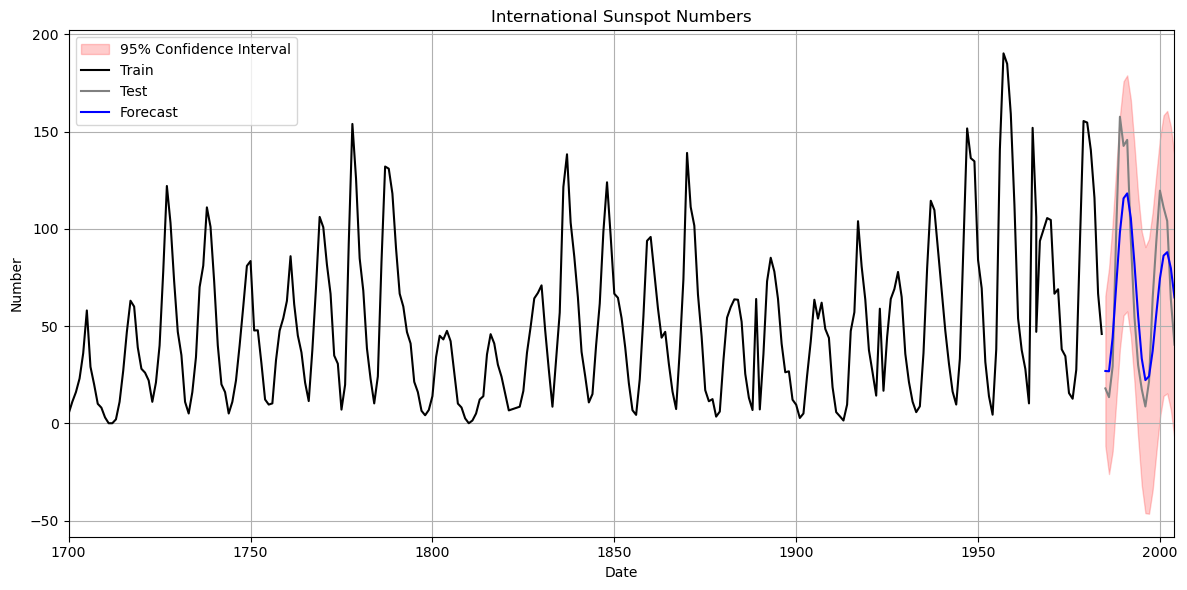

In [61]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(suntest.index,
                 conf_int_20.iloc[:, 0],     # Lower bound
                 conf_int_20.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(suntrain.index, suntrain['Number'], label='Train', color='black')      # Train
plt.plot(suntest.index, suntest['Number'], label='Test', color='gray')          # Test

plt.plot(suntest.index, suntest['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('International Sunspot Numbers')                         
plt.xlabel('Date')                                        
plt.ylabel('Number') 
plt.xlim(1700, 2004)
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();  

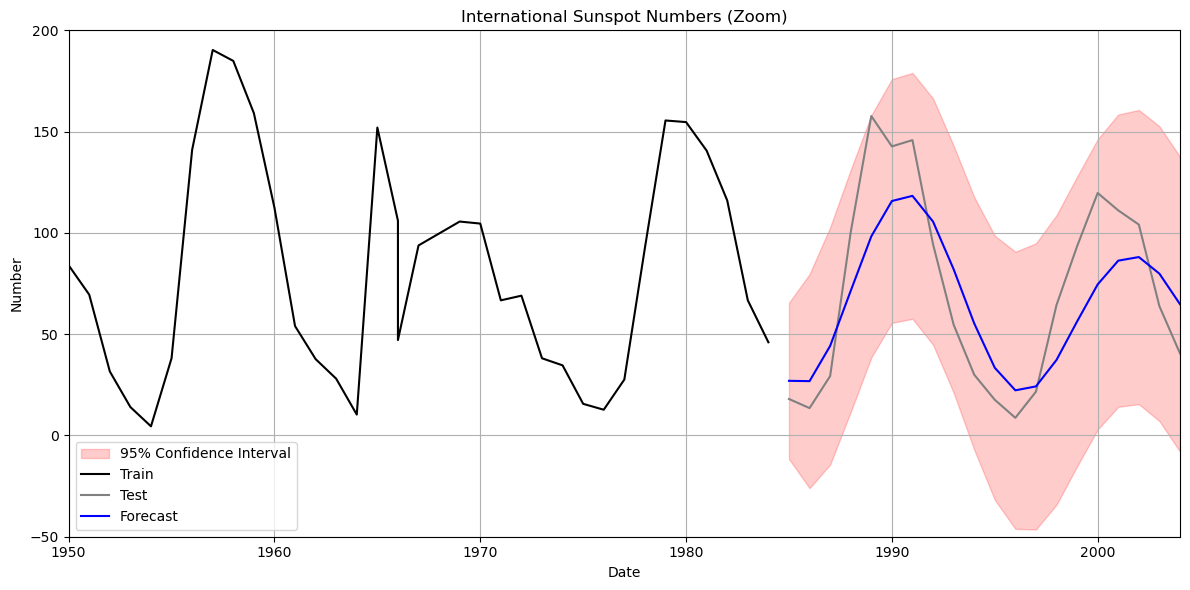

In [62]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(suntest.index,
                 conf_int_20.iloc[:, 0],     # Lower bound
                 conf_int_20.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(suntrain.index, suntrain['Number'], label='Train', color='black')      # Train
plt.plot(suntest.index, suntest['Number'], label='Test', color='gray')          # Test

plt.plot(suntest.index, suntest['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('International Sunspot Numbers (Zoom)')                         
plt.xlabel('Date')                                        
plt.ylabel('Number') 
plt.xlim(1950, 2004)
plt.ylim(-50, 200)
plt.grid(True)                                            
plt.legend(loc=3)                                             
plt.tight_layout()                                       
plt.show();  

In [63]:
rmse = mean_squared_error(suntest['Number'], suntest['Forecast'])
mae = mean_absolute_error(suntest['Number'], suntest['Forecast'])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 708.05
MAE: 23.32
